# Combine steric + BPR + Pair to infer sea level



In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [20]:
# S245
bprfile = '~/data/SWOT_Cruise/FV01/RBRqu/[BB23]_[BB23_REC]_[L245]_[33]_[RBRquartz TP]_[213897]_[no_outfile_append].nc'
stericfile = '~/data/ProjectsActive/SWOT_NAust/DATA/mooring_steric_ssh_S245_v4.nc'
pairfile = '~/data/ProjectsActive/SWOT_NAust/DATA/Australia_Prelude_09-08-2023_0503.csv'
outfile = '~/data/ProjectsActive/SWOT_NAust/DATA/mooring_sealevel_S245_v2.nc'

# W310
bprfile = '/home/jupyter-mrayson/data/SWOT_Cruise/FV01/RBRqu/[BB23]_[BB23_REC]_[W310]_[48]_[RBRquartz TP]_[213895]_[no_outfile_append]_corrected.nc'
stericfile = '~/data/ProjectsActive/SWOT_NAust/DATA/mooring_steric_ssh_W310_v4.nc'
pairfile = '~/data/ProjectsActive/SWOT_NAust/DATA/Australia_Prelude_09-08-2023_0503.csv'
outfile = '~/data/ProjectsActive/SWOT_NAust/DATA/mooring_sealevel_W310_v2.nc'

t1,t2 = '2023-04-22 00:00:00','2023-06-01 00:00:00'

In [21]:
# Load the steric height
ds_sh = xr.open_dataset(stericfile)
ds_sh

<xarray.Dataset>
Dimensions:         (time: 57599, z_nom: 27)
Coordinates:
  * time            (time) datetime64[ns] 2023-04-22T00:00:59.028800 ... 2023...
  * z_nom           (z_nom) float64 -304.9 -300.1 -295.1 ... -27.48 -15.51
    lat_nom         float64 ...
    lon_nom         float64 ...
    name            object ...
Data variables:
    eta_steric      (time) float64 ...
    rho_pr          (z_nom, time) float64 ...
    rho_background  (z_nom) float64 ...
Attributes:
    original file:  [BB23]_[BB23_REC]_[W310]_[multi(27)_nominal_instrument_he...

In [22]:
# Load the bottom pressure
ds = xr.open_dataset(bprfile)
ds_bpr = ds.isel(time=slice(None,None,16)).sel(time=slice(t1,t2))
ds_bpr

<xarray.Dataset>
Dimensions:          (time: 3456001)
Coordinates:
  * time             (time) datetime64[ns] 2023-04-22T00:00:00.937000 ... 202...
    lat_nom          float64 ...
    lon_nom          float64 ...
    z_nom            float64 ...
Data variables:
    BPR_Pressure     (time) float64 ...
    Temperature      (time) float64 ...
    BPR_Temperature  (time) float64 ...
    qc_Temperature   (time) float64 ...
    qc_Pressure      (time) float64 ...
Attributes: (12/35)
    title:                           Measured data from an RBR Data Logger
    institution:                     The University of Western Australia
    institution_division:            Ocean Dynamics
    source:                          RBR Data Logger
    project:                         BB23
    history:                         
    ...                              ...
    nominal_instrument_height_asb:   0.48
    nominal_instrument_orientation:  
    timezone:                        UTC
    process_level:                   1
    is_profile_data:                 0
    pimos_nickname:                  RBRqu

In [23]:
%%time
# Interpolate onto the steric height 
ds_bpr_60s = ds_bpr['BPR_Pressure'].resample(time='60s').mean()
ds_bpr_60s

CPU times: user 16.9 s, sys: 352 ms, total: 17.2 s
Wall time: 39 s


<xarray.DataArray 'BPR_Pressure' (time: 57601)>
array([313.80752801, 313.82614247, 313.84250875, ..., 315.47944195,
       315.48015796, 315.48082759])
Coordinates:
    lat_nom  float64 ...
    lon_nom  float64 ...
    z_nom    float64 ...
  * time     (time) datetime64[ns] 2023-04-22 2023-04-22T00:01:00 ... 2023-06-01
Attributes:
    units:          dbar
    standard_name:  sea_water_pressure
    long_name:      "Sea water pressure" is the pressure that exists in the m...
    qc_variable:    qc_Pressure

In [24]:
da_bpr = ds_bpr_60s.interp({'time':ds_sh.time.values})
da_bpr

<xarray.DataArray 'BPR_Pressure' (time: 57599)>
array([313.82584116, 313.84224383, 313.85967128, ..., 315.47646525,
       315.47939383, 315.48014637])
Coordinates:
    lat_nom  float64 -14.14
    lon_nom  float64 122.8
    z_nom    float64 -309.5
  * time     (time) datetime64[ns] 2023-04-22T00:00:59.028800 ... 2023-05-31T...
Attributes:
    units:          dbar
    standard_name:  sea_water_pressure
    long_name:      "Sea water pressure" is the pressure that exists in the m...
    qc_variable:    qc_Pressure

In [25]:
da_bpr.mean()

<xarray.DataArray 'BPR_Pressure' ()>
array(314.24348203)
Coordinates:
    lat_nom  float64 -14.14
    lon_nom  float64 122.8
    z_nom    float64 -309.5

In [26]:
# Load the air pressure
#pd.read_csv?
df = pd.read_csv(pairfile, header=2, index_col='UTC', parse_dates=True)
da_pair = xr.DataArray(df['BarometricPressure/mbar_10min_Mean']).rename({'UTC':'time'})
da_pair.name = 'Pair'
da_pair

<xarray.DataArray 'Pair' (time: 19699)>
array([1000.90710714, 1000.87490358, 1000.88536667, ..., 1008.65385   ,
       1008.46893333, 1008.31296667])
Coordinates:
  * time     (time) datetime64[ns] 2023-03-22T21:00:00 ... 2023-08-09T05:00:00

In [27]:
# Interpolate onto the steric height points
da_pair_60s = da_pair.interp({'time':ds_sh.time.values})

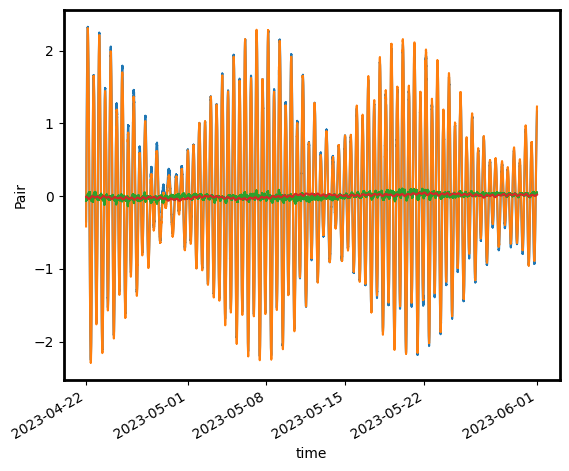

In [28]:
# Calculate sea level
g = 9.81
rho0 = 1024

pb_pr = da_bpr - da_bpr.mean()
pb_pr *= 10000. # decibars to pascals

pa_pr = da_pair_60s - da_pair_60s.mean()
pa_pr *= 100 # hectopascals to pascals

#p_steric = -1*g*rho0 * ds_sh['eta_steric'] # Steric height is stored with a different sign
p_steric = g*rho0 * ds_sh['eta_steric'] # v4 Steric height is stored correct sign

p_steric = p_steric.drop_vars(['lon_nom','lat_nom'])
cff = np.power(g*rho0, -1)
eta = cff * (pb_pr - pa_pr - p_steric)

plt.figure()
eta.plot()
(pb_pr*cff).plot()
(p_steric*cff).plot()
(pa_pr*cff).plot()

In [29]:
from nwatides import fes, hanalysis

In [30]:
%%time
# Get the tides
ilon = np.array([ds_sh.lon_nom.values])
ilat = np.array([ds_sh.lat_nom.values])
time = pd.DatetimeIndex(ds_sh.time.values)
constituents, minor = None, None
eta_tide = fes.tidal_prediction(ilon, ilat, time, 'z')
eta_tide

not broadcasting because len(lon)==len(lat)
CPU times: user 1min 52s, sys: 9.86 s, total: 2min 2s
Wall time: 2min 27s


<xarray.Dataset>
Dimensions:  (lon: 1, lat: 1, time: 57599)
Coordinates:
  * lon      (lon) float64 122.8
  * lat      (lat) float64 -14.14
  * time     (time) datetime64[ns] 2023-04-22T00:00:59.028800 ... 2023-05-31T...
Data variables:
    z_tide   (lon, time) float64 -0.4531 -0.4365 -0.4199 ... 1.186 1.189 1.192

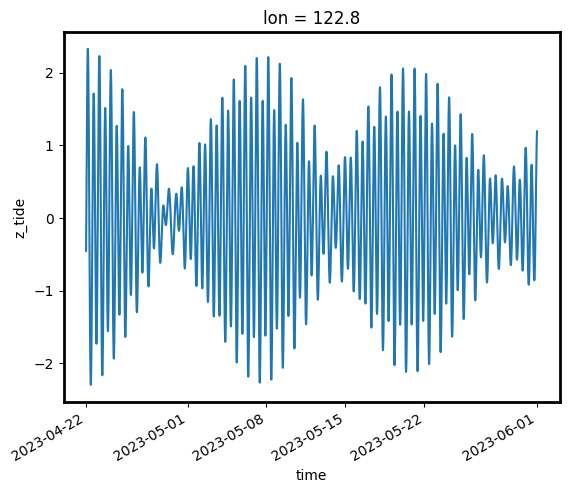

In [31]:
eta_tide['z_tide'].plot()

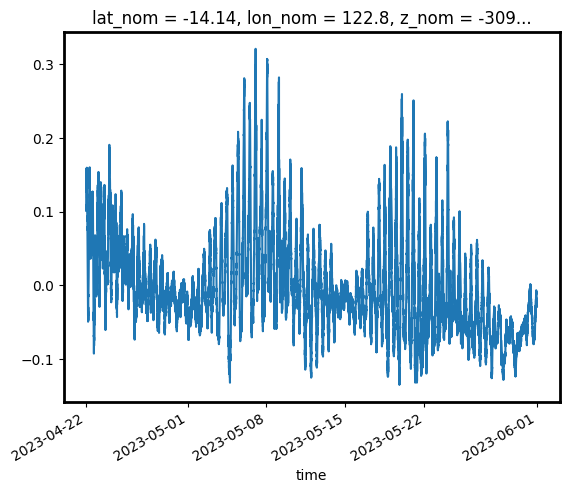

In [32]:
(eta - eta_tide['z_tide']).plot()

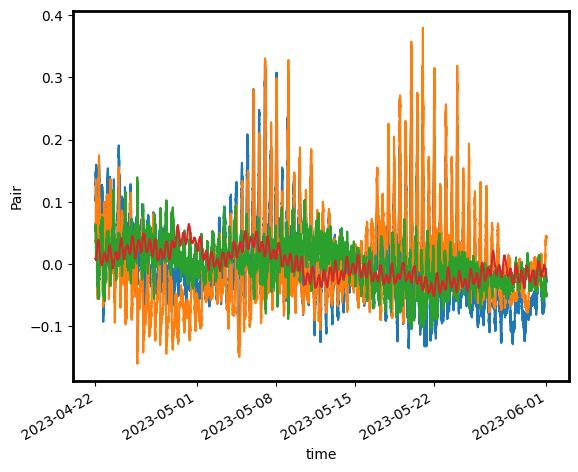

In [33]:
(eta - eta_tide['z_tide']).plot()
(pb_pr*cff- eta_tide['z_tide']).plot()
(-p_steric*cff).plot()
(-pa_pr*cff).plot()

In [34]:
eta_tide

<xarray.Dataset>
Dimensions:  (lon: 1, lat: 1, time: 57599)
Coordinates:
  * lon      (lon) float64 122.8
  * lat      (lat) float64 -14.14
  * time     (time) datetime64[ns] 2023-04-22T00:00:59.028800 ... 2023-05-31T...
Data variables:
    z_tide   (lon, time) float64 -0.4531 -0.4365 -0.4199 ... 1.186 1.189 1.192

In [35]:
# Let's export everything as sea level (units m)
ds_ssh = xr.Dataset(
    {'eta':eta,
    'eta_tide_fes':eta_tide['z_tide'],
    'eta_steric':p_steric*cff,
    'eta_a':pa_pr*cff,
    'eta_b':pb_pr*cff,
    },
)
ds_ssh

<xarray.Dataset>
Dimensions:       (time: 57599, lon: 1)
Coordinates:
    lat_nom       float64 -14.14
    lon_nom       float64 122.8
    z_nom         float64 -309.5
  * time          (time) datetime64[ns] 2023-04-22T00:00:59.028800 ... 2023-0...
    name          <U6 'rho_pr'
  * lon           (lon) float64 122.8
Data variables:
    eta           (time) float64 -0.3468 -0.3318 -0.3147 ... 1.157 1.162 1.164
    eta_tide_fes  (lon, time) float64 -0.4531 -0.4365 -0.4199 ... 1.189 1.192
    eta_steric    (time) float64 -0.06044 -0.05915 -0.05889 ... 0.04839 0.047
    eta_a         (time) float64 -0.008493 -0.008469 ... 0.02031 0.02036
    eta_b         (time) float64 -0.4158 -0.3994 -0.3821 ... 1.227 1.23 1.231

In [36]:
ds_ssh['eta'].attrs = {
    'long_name':'total sea surface height anomaly',
    'units':'m',
    'comments':'eta = (eta_b - eta_a - eta_steric)/(rho0*g)'
}
ds_ssh['eta_a'].attrs = {
    'long_name':'atmospheric pressure contribution to sea surface height anomaly',
    'units':'m',
    'raw_data':pairfile
}

ds_ssh['eta_b'].attrs = {
    'long_name':'bottom pressure contribution to sea surface height anomaly',
    'units':'m',
    'raw_data':bprfile
}

ds_ssh['eta_steric'].attrs = {
    'long_name':'steric height contribution to sea surface height anomaly',
    'units':'m',
    'raw_data':stericfile
}

ds_ssh['eta_tide_fes'].attrs = {
    'long_name':'tidal contribution to sea surface height anomaly',
    'units':'m',
    'raw_data':'FES2014',
}
ds_ssh

<xarray.Dataset>
Dimensions:       (time: 57599, lon: 1)
Coordinates:
    lat_nom       float64 -14.14
    lon_nom       float64 122.8
    z_nom         float64 -309.5
  * time          (time) datetime64[ns] 2023-04-22T00:00:59.028800 ... 2023-0...
    name          <U6 'rho_pr'
  * lon           (lon) float64 122.8
Data variables:
    eta           (time) float64 -0.3468 -0.3318 -0.3147 ... 1.157 1.162 1.164
    eta_tide_fes  (lon, time) float64 -0.4531 -0.4365 -0.4199 ... 1.189 1.192
    eta_steric    (time) float64 -0.06044 -0.05915 -0.05889 ... 0.04839 0.047
    eta_a         (time) float64 -0.008493 -0.008469 ... 0.02031 0.02036
    eta_b         (time) float64 -0.4158 -0.3994 -0.3821 ... 1.227 1.23 1.231

In [37]:
ds_ssh.to_netcdf(outfile)
outfile

'~/data/ProjectsActive/SWOT_NAust/DATA/mooring_sealevel_W310_v2.nc'